In [0]:
#@title
!rm -rf remap_image
!git clone -q https://github.com/LanceNorskog/remap_image.git
%cd /content/remap_image
import scurve.scurve as scurve
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.set_cmap('tab20b')
plt.rcParams['figure.dpi'] = 100
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
from math import radians

# Introduction: Applications of Hilbert Space-Filling Curves to Image Processing

In [0]:
#@title
side = 4
power2 = int(2 ** np.floor(np.sqrt(side * 2)))
hilbertizer = scurve.fromSize('hilbert', 2, power2 * power2)

In [0]:
#@title
ints_mat = np.reshape(np.arange(side * side, dtype='int32'), (side, side))
ints_line = np.reshape(np.arange(side * side, dtype='int32'), (1, side * side))
mapper = np.zeros((side * side), dtype='int32')
for x in range(side):
    for y in range(side):
        xy = hilbertizer.point(x * side + y)
        mapper[xy[0] * side + xy[1]] = x * side + y
ints_mapped_mat = np.reshape(mapper, (side, side))
ints_mapped_line = np.reshape(mapper, (1, side * side))


A space-filling curve is a path through a grid which covers the entire grid, and only touches each square once. There are various types of such paths. The Hilbert space-filling curve is one of a family of such paths. Unlike some paths, the Hilbert space-filling curve is self-similar (fractal) and has really interesting properties for analyzing multi-dimensional data.

This notebook walks through an explanation of how to capture neighborhoods of pixels in a way that is very friendly to deep learning.

![Basic space-filling curve](https://www.bic.mni.mcgill.ca/~mallar/CS-644B/hilbert.gif)

[Good basic explanation of Hilbert space-filling curves](http://www.bic.mni.mcgill.ca/~mallar/CS-644B/hilbert.html)


You can create a Hilbert space-filling curve by folding a square sheet of paper into smaller squares, then cutting a certain pattern through the resulting (thick) set of sheets. (I found one illustration of exactly this, but now cannot locate it.)

# Rearranging a Matrix with the Hilbert Space-Filling Curve

We can rearrange a square matrix using the Hilbert space-filling curve.
The output matrix will have most of the squares in a new position, and each square exists in the target matrix. Squares are not deleted or copied.

The following grids show how cells are numbered in a Hilbert path through a 4x4 grid. The left grid shows the conventional computer memory-based addressing. The right grid shows the path through the grid in cell order.

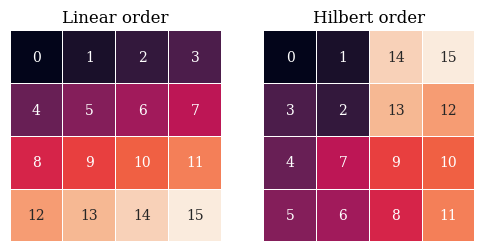

In [4]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Linear order')
ax2.set_title('Hilbert order')
sns.heatmap(ints_mat, ax=ax1, square=True, cbar=False, annot=ints_mat, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(ints_mapped_mat, ax=ax2, square=True, cbar=False, annot=ints_mapped_mat, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

We start with the matrix in linear order...

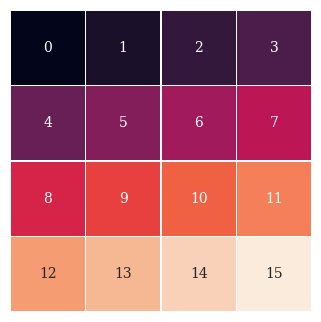

In [5]:
#@title
fig, ax1 = plt.subplots(1, 1)
sns.heatmap(ints_mat, ax=ax1, square=True, cbar=False, annot=ints_mat, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

... unrolls it into a 16-cell vector ...

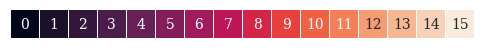

In [6]:
#@title
fig, ax1 = plt.subplots(1, 1)
sns.heatmap(ints_line, ax=ax1, square=True, cbar=False, annot=ints_line, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

... shuffles the contents of each cell to its place along the Hilbert curve...

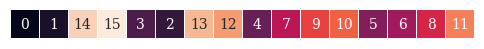

In [7]:
#@title
fig, ax1 = plt.subplots(1, 1)
sns.heatmap(ints_mapped_line, ax=ax1, square=True, cbar=False, annot=ints_mapped_line, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

... then reshapes the resulting vector back into a matrix.

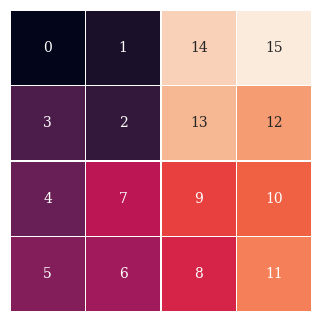

In [8]:
#@title
fig, ax1 = plt.subplots(1, 1)
sns.heatmap(ints_mapped_mat, ax=ax1, square=True, cbar=False, annot=ints_mapped_mat, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

In image-processing terms, this could be called the *Hilbert Convolution*, the *Space-filling curve convolution*, or (my favorite) the *Fractal Scramble*. Hilbert shape-filling curves are defined for all finite dimensions, and thus the Hilbert Convolution can be applied to image, 3D voxel data, and any other (hyper-)cubic tensor.

# Hilbert Mapping as a Matrix Function

The Hilbert mapping can be directly expressed as a function on the unwrapped line in Step 2. Recall from basic linear algebra that the identity matrix is called this because it is the identity function on a vector (or matrix).


$$
\begin{pmatrix} x \\ y \\ z \end{pmatrix} * 
\begin{pmatrix} 
1&0&0 \\
0&1&0 \\
0&0&1
\end{pmatrix}
=
\begin{pmatrix} 
x*1&+&y*0&+&z*0 \\
x*0&+&y*1&+&z*0 \\
x*0&+&y*0&+&z*1 \\
\end{pmatrix}
=
\begin{pmatrix} x \\ y \\ z \end{pmatrix}
$$

The Hilbert mapping function, as a matrix, looks like the identity function shown above, except that the 1's are rearranged. (Given that this matrix has to turn a 16-cell vector into another 16-cell vector, it has to be a 16x16 matrix.)

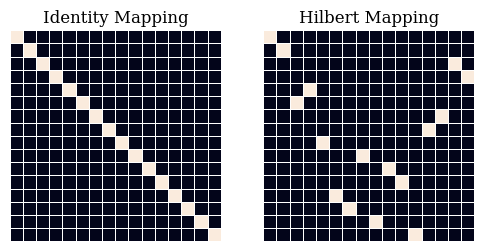

In [9]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Identity Mapping')
ax2.set_title('Hilbert Mapping')

mapping_side = side*side
ident_mapping = np.zeros((mapping_side, mapping_side))
hilbert_mapping = np.zeros((mapping_side, mapping_side))

for x in range(side):
    for y in range(side):
        ident_mapping[x * side + y][x * side + y] = 1
        hilbert_mapping[x * side + y][mapper[x * side + y]] = 1

sns.heatmap(ident_mapping, ax=ax1, square=True, cbar=False,  xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(hilbert_mapping, ax=ax2, square=True, cbar=False, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()


Multiplying a 16-vector by the above Hilbert mapping function gives the rearranged 16-vector:

In [0]:
#@title
sample_data = np.arange(mapping_side)
sample_data_vec = np.reshape(sample_data, (1, mapping_side))
sample_data_sq = np.reshape(sample_data, (side,side))

hilbert_mapped = np.dot(hilbert_mapping, sample_data)
hilbert_mapped_vec = np.reshape(hilbert_mapped, (1, mapping_side))
hilbert_mapped_sq = np.reshape(hilbert_mapped, (side,side))

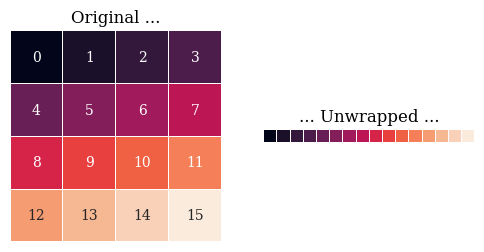

In [11]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Original ...')
ax2.set_title('... Unwrapped ...')


sns.heatmap(sample_data_sq, ax=ax1, square=True, cbar=False, annot=sample_data_sq, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(sample_data_vec, ax=ax2, square=True, cbar=False, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

... multiply this linearized vector by the 16x16 "Hilbert Mapping" matrix above ...

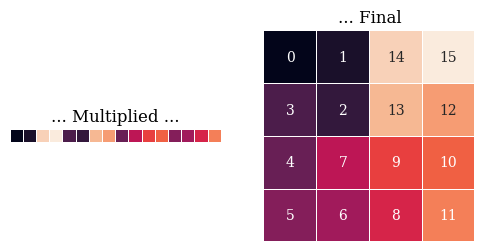

In [12]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('... Multiplied ...')
ax2.set_title('... Final')

sns.heatmap(hilbert_mapped_vec, ax=ax1, square=True, cbar=False, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(hilbert_mapped_sq, ax=ax2, square=True, cbar=False, annot=hilbert_mapped_sq, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

For the three people reading this who like mathematical notation, we take this matrix...

\begin{pmatrix} 
0 & 1 & 2 & 3 \\
4 & 5 & 6 & 7 \\ 
8 & 9 & 10 & 11 \\ 
12&13&14&15 
\end{pmatrix}

express it as a 16-cell vector, multiply it by the above Hilbert mapping function matrix...


$$
\begin{pmatrix} 0 \\ 1 \\ 2 \\ 3 \\ 4 \\ 5 \\ 6 \\ 7 \\ 8 \\ 9 \\ 10 \\ 11 \\ 12 \\ 13 \\ 14 \\ 15 \end{pmatrix} * 
\begin{pmatrix} 
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0 \\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0 \\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1 \\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0 \\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0 \\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0 \\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0 \\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0 \\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0 
\end{pmatrix}
=
\begin{pmatrix} 
0 \\ 1 \\ 14 \\ 15 \\ 3 \\ 2 \\ 13 \\ 12 \\ 4 \\ 7 \\ 9 \\ 10 \\ 5 \\ 6 \\ 8 \\ 11
\end{pmatrix}
$$

... and then wrap the resulting 16-cell vector as a 2D matrix:

\begin{pmatrix} 
0 & 1 & 14 & 15 \\ 3 & 2 & 13 & 12 \\ 4 & 7 & 9 & 10 \\ 5 & 6 & 8 & 11
\end{pmatrix}
